In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer

In [3]:
#data = pd.read_csv("oasis_longitudinal.csv")

In [4]:
# ubaci srednju vrijednost godina tamo gdje nedostaje ta informacija
#data.loc[data.SES.isna(),'SES'] = data.loc[:,'SES'].median()

# izbaci zapise s nedostajućom vrijednosti značajke MMSE
#data = data.loc[data.MMSE.notnull(), :]

In [5]:
data = pd.read_csv("obradeni_podaci.csv")
data

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,M,87,14,2.000000,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,M,88,14,2.000000,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,M,75,12,2.460452,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,M,76,12,2.460452,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,Demented,3,1895,M,80,12,2.460452,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,OAS2_0185,Demented,2,842,M,82,16,1.000000,28.0,0.5,1693,0.694,1.037
367,OAS2_0185,Demented,3,2297,M,86,16,1.000000,26.0,0.5,1688,0.675,1.040
368,OAS2_0186,Nondemented,1,0,F,61,13,2.000000,30.0,0.0,1319,0.801,1.331
369,OAS2_0186,Nondemented,2,763,F,63,13,2.000000,30.0,0.0,1327,0.796,1.323


In [6]:
data = data.groupby('Subject ID').first().reset_index()

In [7]:
#NOVE ZNAČAJKE
data['eTIV_nWBV_Ratio'] = data['eTIV'] / data['nWBV']
data['Education_MMSE'] = data['EDUC'] * data['MMSE']
data['BrainVolume_Education_Ratio'] = data['eTIV'] / data['EDUC']
data['EDUC_nWBV'] = data['EDUC'] / data['nWBV']

In [8]:
data.nunique()

Subject ID                     150
Group                            3
Visit                            1
MR Delay                         1
M/F                              2
Age                             34
EDUC                            12
SES                              6
MMSE                            13
CDR                              3
eTIV                           131
nWBV                            90
ASF                            129
eTIV_nWBV_Ratio                149
Education_MMSE                  55
BrainVolume_Education_Ratio    143
EDUC_nWBV                      138
dtype: int64

In [9]:
data['M/F'] = data['M/F'].map({'M': 0, 'F': 1})

In [36]:
data['CDR'] = data['CDR'].replace({0.5: 1})  #sada imamo samo dvije klase
selected_features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF','eTIV_nWBV_Ratio']
#scaler = StandardScaler()

# Dodajte normalizirane značajke u vaš DataFrame
#data[selected_features] = scaler.fit_transform(data[selected_features])
X = data[selected_features]  # Odabir značajki za X
y = data['CDR'] # Varijabla koju želim predviđati


In [37]:
X

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,eTIV_nWBV_Ratio
0,0,87,14,2.000000,27.0,1987,0.696,0.883,2854.885057
1,0,75,12,2.460452,23.0,1678,0.736,1.046,2279.891304
2,1,88,18,3.000000,28.0,1215,0.710,1.444,1711.267606
3,0,80,12,4.000000,28.0,1689,0.712,1.039,2372.191011
4,0,71,16,2.460452,28.0,1357,0.748,1.293,1814.171123
...,...,...,...,...,...,...,...,...,...
145,0,73,12,2.460452,23.0,1661,0.698,1.056,2379.656160
146,1,66,13,2.000000,30.0,1495,0.746,1.174,2004.021448
147,1,72,16,3.000000,24.0,1354,0.733,1.296,1847.203274
148,0,80,16,1.000000,28.0,1704,0.711,1.030,2396.624473


In [38]:
# Normalizacija/standardizacija značajki
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

MIA KOD-RANDOM FOREST

In [40]:
def cross_check_RF(X_train, X_test, y_train, y_test):
    train_error = []
    test_error = []
    best = 1
    best_depth = 0
    for depth in range(1, 16):
        model_random_forest = RandomForestClassifier(max_depth=depth).fit(X_train, y_train.reshape(1, -1).flatten())
        train_err = 1-accuracy_score(y_train.reshape(1, -1).flatten(), model_random_forest.predict(X_train))
        test_err = 1-accuracy_score(y_test.reshape(1, -1).flatten(), model_random_forest.predict(X_test))
        train_error.append(train_err)
        test_error.append(test_err)
        
        if test_err < best:
            best_depth = depth
        
    return train_error, test_error, best_depth

15


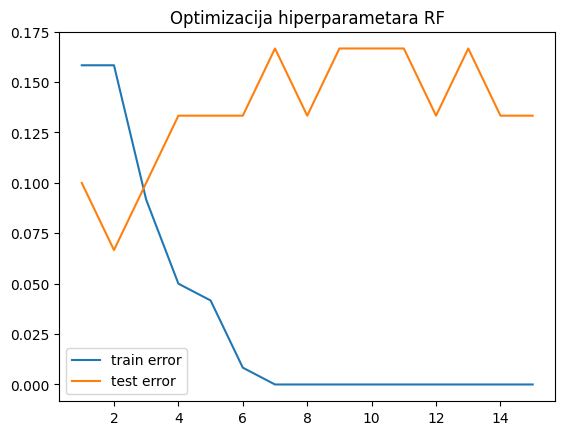

In [41]:
train_err, test_err, best_depth = cross_check_RF(X_train, X_test, y_train, y_test)
print(best_depth)

plt.plot(range(1, 16), train_err, label=f'train error')
plt.plot(range(1, 16), test_err, label=f'test error')
plt.title("Optimizacija hiperparametara RF")
plt.legend(loc = 'best')

In [42]:
def train_rand_forest(X_train, X_test, y_train, y_test, max_depth=None, num_of_classes=2):
    
    model = RandomForestClassifier(max_depth=max_depth).fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_results = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Random Forest): {np.mean(cv_results)}')

    acc = accuracy_score(y_test, model.predict(X_test))
    print(f'accuracy: {acc}')

    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    print(f'confusion matrix:\n{conf_matrix}\n')
    
    # ROC Curve for binary classification
    if len(set(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()

Cross-Validation Accuracy (Random Forest): 0.8666666666666666
accuracy: 0.8333333333333334
confusion matrix:
[[17  5]
 [ 0  8]]



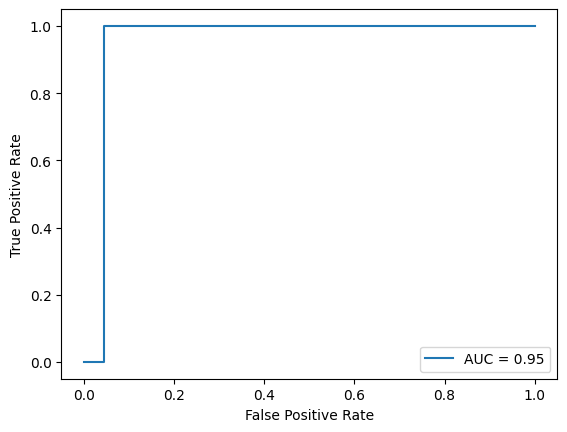

In [43]:
train_rand_forest(X_train, X_test, y_train.ravel(), y_test, max_depth=best_depth)

In [44]:
#PETRIN KOD:
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,  # Max depth of trees
    min_samples_leaf=2,  # Minimum samples per leaf
    max_features='sqrt',  # Number of features to consider at each split
    random_state=42  # Setting a random state for reproducibility
)


# Fit the model on your training data
rf_classifier.fit(X_train, y_train)
predictions_rf = rf_classifier.predict(X_test)


accuracy_rf = rf_classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy_rf}")
f1_rf = f1_score(y_test,predictions_rf,average='micro')
precision_rf = precision_score(y_test,predictions_rf,average='micro')
recall_rf = recall_score(y_test, predictions_rf,average='micro')
print("F1_score: ",f1_rf)
print("Precision : ",precision_rf)
print("Recall : ",recall_rf)

Accuracy: 0.9
F1_score:  0.9
Precision :  0.9
Recall :  0.9


SVM-PETRA

In [45]:
svm_classifier = SVC(kernel='linear', probability=True)  # You can specify the kernel type ('linear', 'rbf', 'poly', etc.)
svm_classifier.fit(X_train, y_train)
# Making predictions on the test set using the best estimator
y_predict_svm = svm_classifier.predict(X_test)

# Calculating accuracy
accuracy_svm = accuracy_score(y_test, y_predict_svm)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.8


SVM-MIA

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

In [46]:

def cross_check_SVM(X_train, X_test, y_train, y_test):
    train_error = []
    test_error = []
    best = 1
    best_depth = 0
    for depth in range(1, 16):
        model_random_forest = RandomForestClassifier(max_depth=depth).fit(X_train, y_train.reshape(1, -1).flatten())
        train_err = 1-accuracy_score(y_train.reshape(1, -1).flatten(), model_random_forest.predict(X_train))
        test_err = 1-accuracy_score(y_test.reshape(1, -1).flatten(), model_random_forest.predict(X_test))
        train_error.append(train_err)
        test_error.append(test_err)
        
        if test_err < best:
            best_depth = depth
        
    return train_error, test_error, best_depth

def train_svm(X_train, X_test, y_train, y_test, kernel="linear", C=0.1, num_folds=10):
    model = SVC(kernel=kernel, C=C, probability=True).fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (SVM): {np.mean(cv_results)}')

    acc = accuracy_score(y_test, model.predict(X_test))
    print(f'Accuracy (SVM): {acc}')

    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    print(f'Confusion Matrix (SVM):\n{conf_matrix}\n')

    # ROC Curve for binary classification
    if len(set(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()


Cross-Validation Accuracy (SVM): 0.8083333333333332
Accuracy (SVM): 0.9333333333333333
Confusion Matrix (SVM):
[[20  2]
 [ 0  8]]



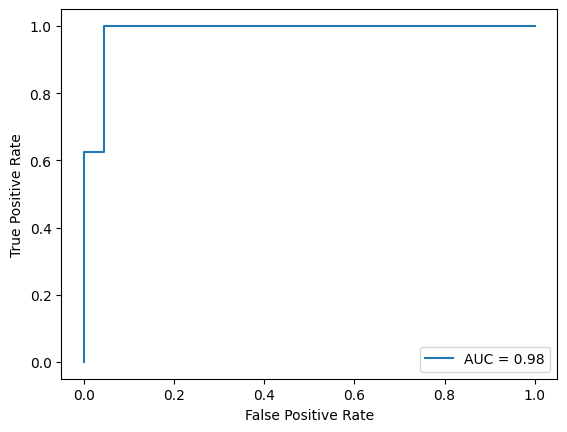

In [47]:
train_svm(X_train, X_test, y_train, y_test)

VOTING-MIA

In [48]:
def train_voting(X_train, X_test, y_train, y_test, num_folds=10):
    rf_model = RandomForestClassifier(max_depth=10)
    svm_model = SVC(kernel="linear", C=0.1, probability=True)
    xgb_model = XGBClassifier()
    df_model = DecisionTreeClassifier()

    voting_model = VotingClassifier(estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('df', df_model )
    ], voting='soft').fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_results = cross_val_score(voting_model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Voting): {np.mean(cv_results)}')

    acc = accuracy_score(y_test, voting_model.predict(X_test))
    print(f'Accuracy (Voting): {acc}')

    conf_matrix = confusion_matrix(y_test, voting_model.predict(X_test))
    print(f'Confusion Matrix (Voting):\n{conf_matrix}\n')

    # ROC Curve for binary classification
    if len(set(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, voting_model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()

Cross-Validation Accuracy (Voting): 0.8
Accuracy (Voting): 0.9
Confusion Matrix (Voting):
[[19  3]
 [ 0  8]]



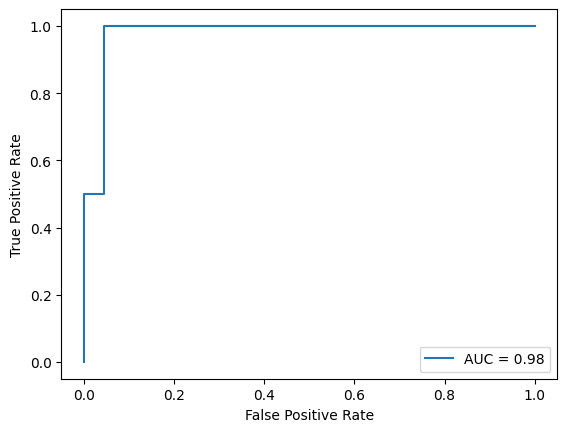

In [49]:
train_voting(X_train, X_test, y_train, y_test)

XGBOOST MIA

Cross-Validation Accuracy (XGBoost): 0.8166666666666668
Accuracy (XGBoost): 0.8333333333333334
Confusion Matrix (XGBoost):
[[17  5]
 [ 0  8]]



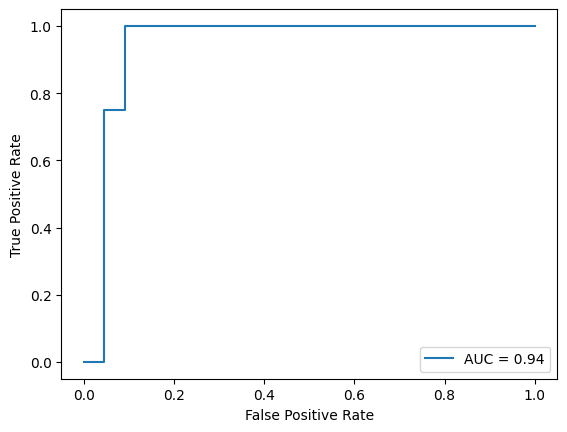

In [50]:
def train_xgboost(X_train, X_test, y_train, y_test, num_folds=10):
    model = XGBClassifier().fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (XGBoost): {np.mean(cv_results)}')

    acc = accuracy_score(y_test, model.predict(X_test))
    print(f'Accuracy (XGBoost): {acc}')

    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    print(f'Confusion Matrix (XGBoost):\n{conf_matrix}\n')

    # ROC Curve for binary classification
    if len(set(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()
train_xgboost(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

def train_ensemble_models(X_train, X_test, y_train, y_test):
    # Define base models
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    logreg_model = LogisticRegression(random_state=42)

    # Create an ensemble model using VotingClassifier
    ensemble_model = VotingClassifier(estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('logreg', logreg_model)
    ], voting='hard')

    # Fit the ensemble model
    ensemble_model.fit(X_train, y_train)

    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(ensemble_model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Ensemble): {np.mean(cv_results)}')

    # Evaluate on the test set
    y_pred = ensemble_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy (Ensemble): {acc}')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix (Ensemble):\n{conf_matrix}\n')



# Call the function
train_ensemble_models(X_train, X_test, y_train, y_test)


LOGISTIC REGRESSION

In [51]:
from sklearn.model_selection import GridSearchCV

# Create a logistic regression model
logreg_model = LogisticRegression(max_iter=2000)

# Define the parameter grid
param_grid = {'C': [10**-2, 1, 10**2]}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)  # Adjust cv as needed
grid_search.fit(X_train, y_train.ravel())

# Get the best model and print results
best_model = grid_search.best_estimator_
best_accuracy = accuracy_score(y_test, best_model.predict(X_test))

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {best_accuracy}')


Best Parameters: {'C': 1}
Best Accuracy: 0.8666666666666667
